# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [53]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
from odc.geo.geom import Geometry
from odc.ui import select_on_a_map

from intertidal.utils import (
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines
from dea_tools.dask import create_local_dask_cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup


### Set analysis parameters

In [3]:
# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
# tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### Set study area

##### Option 1: load study area from 32 km tile GridSpec

In [ ]:
# Set study area (e.g. tile ID in form 'x143y87')
study_area = "x133y40"
geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

In [ ]:
# # Set study area to load from file
# study_area = "pointstuart"

# # Read file, select study area and convert to geom
# studyarea_gdf = gpd.read_file(
#     "data/raw/intertidal_development_polygons.geojson"
# ).set_index("id")
# geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
# geom

##### Option 3: load study area using interactive map

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

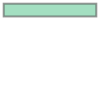

In [30]:
# Set study area name for outputs
study_area = "extents1"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

## Intertidal workflow

### Load data

In [31]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()

/env/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33325 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33325/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33325/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36975,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33325/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:40543,Total threads: 15
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33511/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:34707,


<xarray.Dataset>
Dimensions:      (time: 286, y: 858, x: 2941)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-05T00:08:40.158000 ... 2021-12...
  * y            (y) float64 -4.757e+06 -4.757e+06 ... -4.765e+06 -4.765e+06
  * x            (x) float64 1.286e+06 1.286e+06 ... 1.316e+06 1.316e+06
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 858, 1600), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 12.5 s, sys: 3.36 s, total: 15.9 s
Wall time: 1min 30s


<xarray.Dataset>
Dimensions:      (time: 286, y: 858, x: 2941)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-05T00:08:40.158000 ... 2021-12...
  * y            (y) float64 -4.757e+06 -4.757e+06 ... -4.765e+06 -4.765e+06
  * x            (x) float64 1.286e+06 1.286e+06 ... 1.316e+06 1.316e+06
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [32]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [33]:
# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

2023-12-15 01:35:41 INFO Modelling tide heights for each pixel


Creating reduced resolution 3000 x 3000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:23<00:00,  1.49it/s]


Returning low resolution tide array
Generating ensemble tide model from point inputs


2023-12-15 01:36:19 INFO Masking nodata and adding tide heights to satellite data array
2023-12-15 01:36:22 INFO Flattening satellite data array and filtering to intertidal candidate pixels
2023-12-15 01:36:22 INFO Applying valid data mask to constrain study area
2023-12-15 01:36:51 INFO Running per-pixel rolling median


Reducing analysed pixels from 2517981 to 173732 (6.90%)


  0%|          | 0/105 [00:00<?, ?it/s]

2023-12-15 01:39:05 INFO Modelling intertidal elevation


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


2023-12-15 01:39:07 INFO Modelling intertidal uncertainty
2023-12-15 01:39:09,897 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-15 01:39:10,302 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-15 01:39:11,106 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-15 01:39:11,461 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-15 01:39:11,847 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-15 01:39:12,742 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-15 01:39:13,089 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-15 01:39:13,480 - distri

In [41]:
ds_aux

<xarray.Dataset>
Dimensions:                 (y: 858, x: 2941)
Coordinates:
  * y                       (y) float64 -4.757e+06 -4.757e+06 ... -4.765e+06
  * x                       (x) float64 1.286e+06 1.286e+06 ... 1.316e+06
    spatial_ref             int32 3577
Data variables:
    misclassified_px_count  (y, x) float64 nan nan nan nan ... nan nan nan nan
    ndwi_tide_corr          (y, x) float64 0.147 0.1648 0.1278 ... nan nan nan
    ndwi_wet_freq           (y, x) float64 0.8722 0.8571 ... 0.005714 0.00578

In [42]:
ds_aux.ndwi_tide_corr

<xarray.DataArray 'ndwi_tide_corr' (y: 858, x: 2941)>
array([[0.14703468, 0.16481667, 0.12776036, ...,        nan,        nan,
               nan],
       [0.14585204, 0.13130384, 0.13130386, ...,        nan,        nan,
               nan],
       [0.04555025, 0.02433841, 0.05763636, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * y            (y) float64 -4.757e+06 -4.757e+06 ... -4.765e+06 -4.765e+06
  * x            (x) float64 1.286e+06 1.286e+06 ... 1.316e+06 1.316e+06
    spatial_ref  int32 3577

### Intertidal extents


In [56]:
ds["extents"] = extents(freq=ds_aux.ndwi_wet_freq, dem=ds.elevation, corr=ds_aux.ndwi_tide_corr)

BOOO


In [57]:
ds.extents.odc.write_cog("extents_newv2.tif", overwrite=True)

PosixPath('extents_newv2.tif')

In [51]:
ds.elevation.odc.write_cog("elevation.tif", overwrite=True)

PosixPath('elevation.tif')

In [48]:
import xarray as xr
import numpy as np

import datacube
from skimage.measure import label, regionprops
from skimage.morphology import binary_erosion, disk

from odc.algo import mask_cleanup
from odc.geo.geom import Geometry
import rioxarray
import odc.geo.xr


def load_reproject(
    path, gbox, name=None, chunks={"x": 2048, "y": 2048}, **reproj_kwargs
):
    """
    Load and reproject part of a raster dataset into a given GeoBox.
    """
    ds = (
        rioxarray.open_rasterio(
            path,
            masked=True,
            chunks=chunks,
        )
        .squeeze("band")
        .odc.reproject(how=gbox, **reproj_kwargs)
    )
    ds.name = name

    return ds


def intertidal_connection(water_intertidal, intertidal, connectivity=1):
    """

    Identifies areas of water pixels that are adjacent to or directly 
    connected to intertidal pixels.
    
    Parameters:
    -----------
    water_intertidal : xarray.DataArray
        An array containing True for pixels that are either water or
        intertidal pixels.
    intertidal : xarray.DataArray
        An array containing True for intertidal pixels. 
    connectivity : integer, optional
        An integer passed to the 'connectivity' parameter of the
        `skimage.measure.label` function.
    
    Returns:
    --------
    intertidal_connection : xarray.DataArray
        An array containing the a mask consisting of identified 
        intertidally-connected pixels as True.
    """

    # First, break `water_intertidal` array into unique, discrete 
    # regions/blobs.
    blobs = xr.apply_ufunc(label, water_intertidal, 0, False, connectivity)

    # For each unique region/blob, use region properties to determine
    # whether it overlaps with a feature from `intertidal`. If
    # it does, then it is considered to be adjacent or directly connected
    # to intertidal pixels
    intertidal_connection = blobs.isin(
        [i.label for i in regionprops(blobs.values, intertidal.values) if i.max_intensity]
    )

    return intertidal_connection


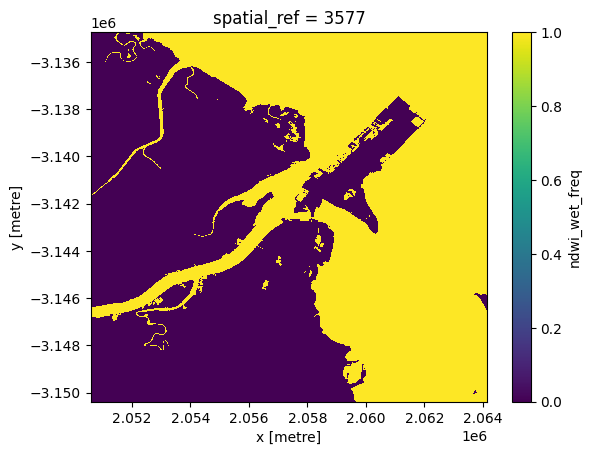

In [25]:
intertidal_connection(~wet_intertidal, inter, connectivity=1).plot()

In [ ]:
land_use_mask="/gdata1/data/land_use/ABARES_CLUM/geotiff_clum_50m1220m/clum_50m1220m.tif"
freq=ds_aux.ndwi_wet_freq
dem=ds.elevation
corr=ds_aux.ndwi_tide_corr

## Load the land use dataset to mask out misclassified extents classes caused by urban land class
landuse_ds = load_reproject(
path=land_use_mask,
gbox=dem.odc.geobox,
resampling="nearest",
).compute()

## Separate out the 'intensive urban' land use summary class and set all other pixels to False

reclassified = xr.where((landuse_ds==500),16,landuse_ds)#Urban intensive uses
reclassified = xr.where((landuse_ds>=530)&(landuse_ds<=538),16,reclassified)#Urban intensive uses
reclassified = xr.where((landuse_ds>=540)&(landuse_ds<=541),16,reclassified)#Urban intensive uses
reclassified = xr.where((landuse_ds>=550)&(landuse_ds<=555),16,reclassified)#Urban intensive uses
reclassified = xr.where((landuse_ds>=560)&(landuse_ds<=567),16,reclassified)#Urban intensive uses
reclassified = xr.where((landuse_ds>=570)&(landuse_ds<=575),16,reclassified)#Urban intensive uses

reclassified = xr.where(reclassified==16,True,False)

'''--------------------------------------------------------------------'''
## Set the upper and lower freq thresholds
upper, lower = 0.99, 0.01

'''--------------------------------------------------------------------'''
## Identify broad classes based on wetness frequency and tidal correlation
dry = freq.where((freq < lower), drop=True)
intermittent = freq.where((freq>=lower)&(freq<=upper),np.nan)
wet = freq.where((freq>upper),np.nan)

##### Separate intermittent_tidal (intertidal)
intertidal = freq.where(
                    (freq==intermittent)
                    &(corr>=0.15),
                    drop=True
                    )

##### Separate intermittent_nontidal
intermittent_nontidal = freq.where(
                    (freq==intermittent)
                    &(corr<0.15),
                    drop=False
                    )

##### Separate high and low confidence intertidal pixels
intertidal_hc = intertidal.where(dem.notnull(),drop=True)
intertidal_lc = intertidal.where(dem.isnull(),drop=True)
'''--------------------------------------------------------------------'''
## Clean up the urban land masking class by removing high confidence intertidal areas
reclassified = reclassified.where(~dem.notnull(),False)

## Erode the intensive urban land use class to remove extents-class overlaps from 
## the native 50m CLUM pixel resolution dataset
reclassified = mask_cleanup(mask=reclassified, mask_filters=[("erosion",5)])
'''--------------------------------------------------------------------'''
##### Classify 'wet' pixels based on connectivity to intertidal pixels (into 'wet_ocean' and 'wet_inland')

## Create the 'always wet + intertidal' ds to compare against 'intertidal' pixels
## only for intertidal connectivity
wet_intertidal = xr.where(freq>=lower,0,1)

## If deep-sea masked pixels, replace Nans with 'wet' boolean (0)
if freq.isnull().any()==True is True:
    wet_intertidal = wet_intertidal.where(freq.notnull(), 0)

## Create a true/false layer of intertidal pixels (1) vs everything else (0)
# # Extract intertidal pixels (value 1) then erode these by 1 pixels to ensure we only
# # use high certainty intertidal regions for identifying connectivity to wet
# # pixels in our satellite imagery.
inter = freq.where((freq>=lower)&
                      (freq<=upper)&
                      (corr>=0.15))
## Convert to true/false
inter = xr.where(freq==inter,True,False)
## Drop Nans
if freq.isnull().any()==True is True:
    inter = inter.where(freq.notnull(), drop=True)

## Erode outer edge pixels by 1 pixel to drop extrema intertidal pixels and ensure connection 
## to high certainty intertidal pixels (POSSIBLY UNNECCESARY due to corr definition of intertidal pixels)
inter = xr.apply_ufunc(binary_erosion, inter == 1, disk(1))

## Applying intertidal_connection masking function for the first of two times
## This first mask identifies where wet+intertidal pixels connect to intertidal pixels
intertidal_mask1 = intertidal_connection(wet_intertidal, inter, connectivity=1)

## Prepare data to test for wet pixel connection to the connected 'wet and intertidal' mask.
## Identify and relabel the pixels in 'freq' that are 'wet (0)' and 'other (1)'.
wet_bool = xr.where(freq==wet,False,True)
## If deep-sea masked pixels, replace Nans with 'wet' boolean (0)
if freq.isnull().any()==True is True:
    wet_bool = wet_bool.where(freq.notnull(), 0)

# ## Applying intertidal_connection masking function for the second time
intertidal_mask2 = intertidal_connection(wet_bool, intertidal_mask1, connectivity=1)

## Mask out areas identified as 'intensive urban use' in ABARES CLUM dataset
intertidal_mask2 = xr.where(reclassified.where(intertidal_mask2==True),False,True, keep_attrs=True) 

# ## distinguish wet inland class from wet ocean class
wet_inland = wet_bool.where((wet_bool==0) & (intertidal_mask2 == False))#, drop=True) ## Weird artefacts when drop=True
wet_ocean = wet_bool.where((wet_bool==0) & (intertidal_mask2 == True), drop=True)

'''--------------------------------------------------------------------'''
## Classify 'intermittently wet' pixels into 'intermittently_wet_inland' and 'other-intertidal_fringe'
## Identify and relabel the pixels in 'freq' that are 'intermittent_nontidal wet (0)' and 'other (1)'.
int_nt = xr.where(freq==intermittent_nontidal,False,True)
## If deep-sea masked pixels, replace Nans with 'wet' boolean (0)
if freq.isnull().any()==True is True:
    int_nt = int_nt.where(freq.notnull(), 0)

## Applying intertidal_connection masking function to separate inland from intertidal connected pixels
intertidal_mask = intertidal_connection(int_nt, intertidal_mask1, connectivity=1)

## Mask out areas identified as 'intensive urban use' in ABARES CLUM dataset
intertidal_mask = xr.where(reclassified.where(intertidal_mask==True),False,True, keep_attrs=True)

# ## distinguish intermittent inland from intermittent-other (intertidal_fringe) pixels
intermittent_inland = int_nt.where((int_nt==0) & (intertidal_mask == False))#, drop=True) ## Weird artefacts when drop=True
intertidal_fringe = int_nt.where((int_nt==0) & (intertidal_mask == True), drop=True)

## Isolate mostly dry pixels from intertidal_fringe class
mostly_dry = intertidal_fringe.where(freq < 0.1, drop=True)
## Isolate mostly wet pixels from intertidal fringe class
mostly_wet = intertidal_fringe.where(freq >= 0.1, drop=True)

##Separate misclassified urban pixels into 'dry' class
urban_dry = reclassified.where((reclassified==True)&(intermittent_inland.notnull()))
urban_dry1 = reclassified.where((reclassified==True)&(intertidal_hc.notnull()))
urban_dry2 = reclassified.where((reclassified==True)&(intertidal_lc.notnull()))

##Identify true classified classes
intermittent_inland = intermittent_inland.where(urban_dry.isnull())
intertidal_hc = intertidal_hc.where(urban_dry1.isnull())
intertidal_lc = intertidal_lc.where(urban_dry2.isnull())

'''--------------------------------------------------------------------'''
## Combine wet_ocean and intertidal_fringe pixels
wet_ocean = wet_ocean.combine_first(mostly_wet)

## Combine urban_dry classes
urban_dry = urban_dry.combine_first(urban_dry1)
urban_dry = urban_dry.combine_first(urban_dry2)

# # ## Relabel pixels
dry = dry.where(dry.isnull(), 0)
wet_ocean = wet_ocean.where(wet_ocean.isnull(),3)
wet_inland = wet_inland.where(wet_inland.isnull(),2)
intermittent_inland = intermittent_inland.where(intermittent_inland.isnull(),1)
intertidal_hc = intertidal_hc.where(intertidal_hc.isnull(),4)
intertidal_lc = intertidal_lc.where(intertidal_lc.isnull(),5)
mostly_dry = mostly_dry.where(mostly_dry.isnull(),0)
urban_dry = urban_dry.where(urban_dry.isnull(),0)

## Combine
extents = dry.combine_first(wet_ocean)
extents = extents.combine_first(wet_inland)
extents = extents.combine_first(intertidal_hc)
extents = extents.combine_first(intermittent_inland)
extents = extents.combine_first(intertidal_lc)
extents = extents.combine_first(mostly_dry)
extents = extents.combine_first(urban_dry)   

In [ ]:
extents.odc.write_cog("extents_old.tif")

In [49]:
land_use_mask="/gdata1/data/land_use/ABARES_CLUM/geotiff_clum_50m1220m/clum_50m1220m.tif"
freq=ds_aux.ndwi_wet_freq
dem=ds.elevation
corr=ds_aux.ndwi_tide_corr

# Load the land use dataset to mask out misclassified extents classes caused by urban land class
landuse_ds = load_reproject(
    path=land_use_mask,
    gbox=dem.odc.geobox,
    resampling="nearest",
).compute()

# Separate out the 'intensive urban' land use summary class and set 
# all other pixels to False
reclassified = landuse_ds.isin(
    [500, 530, 531, 532, 533, 534, 535, 536, 537, 538, 540, 541, 
     550, 551, 552, 553, 554, 555, 560, 561, 562, 563, 564, 565, 
     566, 567, 570, 571, 572, 573, 574, 575]
)

"""--------------------------------------------------------------------"""
## Set the upper and lower freq thresholds
upper, lower = 0.99, 0.01

# Set NaN values in frequency to 1
freq = freq.fillna(1)

## Identify broad classes based on wetness frequency and tidal correlation
dry = freq < lower
intermittent = (freq >= lower) & (freq <= upper)
wet = freq > upper

##### Separate intermittent_tidal (intertidal)
intertidal = intermittent & (corr >= 0.15)

##### Separate intermittent_nontidal
intermittent_nontidal = intermittent & (corr < 0.15)

##### Separate high and low confidence intertidal pixels
intertidal_hc = intertidal & dem.notnull()
intertidal_lc = intertidal & dem.isnull()

"""--------------------------------------------------------------------"""
# Clean up the urban land masking class by removing high confidence intertidal areas
reclassified = reclassified & ~intertidal_hc

# Erode the intensive urban land use class to remove extents-class overlaps from
# the native 50m CLUM pixel resolution dataset
reclassified = mask_cleanup(mask=reclassified, mask_filters=[("erosion", 5)])

##### Classify 'wet' pixels based on connectivity to intertidal pixels (into 'wet_ocean' and 'wet_inland')

# Create a true/false layer of intertidal pixels (1) vs everything else (0)
# Extract intertidal pixels (value 1) then erode these by 1 pixels to ensure we only
# use high certainty intertidal regions for identifying connectivity to wet
# pixels in our satellite imagery.
inter = intertidal_hc | intertidal_lc

# Erode outer edge pixels by 1 pixel to drop extrema intertidal pixels and ensure connection 
# to high certainty intertidal pixels
inter = xr.apply_ufunc(binary_erosion, inter, disk(1))

# Applying intertidal_connection masking function for the first of two times
# This first mask identifies where wet+intertidal (e.g. not dry) pixels 
# connect to intertidal pixels
intertidal_mask1 = intertidal_connection(~dry, inter, connectivity=1)

# Applying intertidal_connection masking function for the second time,
# testing for wet pixel connection to the connected 'wet and intertidal' mask.
intertidal_mask2 = intertidal_connection(wet, intertidal_mask1, connectivity=1)

# Mask out areas identified as 'intensive urban use' in ABARES CLUM dataset
intertidal_mask2 = intertidal_mask2 & ~reclassified

# Distinguish wet inland class from wet ocean class
wet_inland = ~wet_bool & ~intertidal_mask2
wet_ocean = ~wet_bool & intertidal_mask2

'''--------------------------------------------------------------------'''
## Classify 'intermittently wet' pixels into 'intermittently_wet_inland' and 'other-intertidal_fringe'

## Applying intertidal_connection masking function to separate inland from intertidal connected pixels
intertidal_mask = intertidal_connection(intermittent_nontidal, intertidal_mask1, connectivity=1)

# Mask out areas identified as 'intensive urban use' in ABARES CLUM dataset
intertidal_mask = intertidal_mask & ~reclassified

# Distinguish intermittent inland from intermittent-other (intertidal_fringe) pixels
intermittent_inland = ~int_nt & ~intertidal_mask
intertidal_fringe = ~int_nt & intertidal_mask

# Isolate mostly dry pixels from intertidal_fringe class
mostly_dry = intertidal_fringe & (freq < 0.1)
# Isolate mostly wet pixels from intertidal fringe class
mostly_wet = intertidal_fringe & (freq >= 0.1)

# Separate misclassified urban pixels into 'dry' class
urban_dry = (reclassified & intermittent_inland)
urban_dry1 = (reclassified & intertidal_hc)
urban_dry2 = (reclassified & intertidal_lc)

#Identify true classified classes
intermittent_inland = intermittent_inland & ~urban_dry
intertidal_hc = intertidal_hc & ~urban_dry1
intertidal_lc = intertidal_lc & ~urban_dry2

'''--------------------------------------------------------------------'''
# Combine wet_ocean and intertidal_fringe pixels
wet_ocean = wet_ocean | mostly_wet 

# Combine urban_dry classes
urban_dry = urban_dry1 | urban_dry2

# Relabel pixels
dry = (dry * 0).where(dry)
wet_ocean = (wet_ocean * 3).where(wet_ocean)
wet_inland = (wet_inland * 2).where(wet_inland)
intermittent_inland = (intermittent_inland * 1).where(intermittent_inland)
intertidal_hc = (intertidal_hc * 4).where(intertidal_hc)
intertidal_lc = (intertidal_lc * 5).where(intertidal_lc)
mostly_dry = (mostly_dry * 0).where(mostly_dry)
urban_dry = (urban_dry * 0).where(urban_dry)

# Combine
extents = dry.combine_first(wet_ocean)
extents = extents.combine_first(wet_inland)
extents = extents.combine_first(intertidal_hc)
extents = extents.combine_first(intermittent_inland)
extents = extents.combine_first(intertidal_lc)
extents = extents.combine_first(mostly_dry)
extents = extents.combine_first(0)


In [50]:
ds.extents.odc.write_cog("extents_new.tif", overwrite=True)

PosixPath('extents_new.tif')

In [17]:
reclassified.astype(np.int16).odc.write_cog("extents_urban.tif", overwrite=True)

PosixPath('extents_urban.tif')

### Intertidal exposure
Calculate exposure using the script function

In [ ]:
# ds["exposure"], tide_cq = exposure(
#     dem=ds.elevation,
#     time_range=all_timerange,
#     tide_model=tide_model,
#     tide_model_dir=tide_model_dir,
# )

### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [ ]:
# (
#     ds["oa_lat"],
#     ds["oa_hat"],
#     ds["oa_lot"],
#     ds["oa_hot"],
#     ds["oa_spread"],
#     ds["oa_offset_lowtide"],
#     ds["oa_offset_hightide"],
# ) = bias_offset(
#     tide_m=tide_m, tide_cq=tide_cq, extents=ds.extents, lot_hot=True, lat_hat=True
# )

### Tideline confidence

In [ ]:
# (hightideline, lowtideline, tidelines_gdf) = tidal_offset_tidelines(
#     extents=ds.extents,
#     offset_hightide=ds.oa_offset_hightide,
#     offset_lowtide=ds.oa_offset_lowtide,
#     distance=250,
# )

## Plot all layers

In [ ]:
# Inspect contents of ds before plotting
ds

In [ ]:
fig = plt.figure(figsize=(16, 18), tight_layout=True)
ax_dict = fig.subplot_mosaic(
    """
    AAAABBBBCCCC
    DDDEEEFFFGGG
    HHHIIIJJJKKK
    LLLMMM......
    """,
    height_ratios=[1, 0.8, 0.8, 0.8],
)

# label_params = dict(add_labels=False, yticks=[], xticks=[])

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(
    ax=ax_dict["A"],
    cmap="viridis",
    interpolation="bilinear",
)
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).plot.imshow(
    ax=ax_dict["A"],
    interpolation="bilinear",
)
ax_dict["A"].set_title("Elevation (metres AMSL)")

# Plot uncertainty
ds["elevation_uncertainty"].plot.imshow(
    ax=ax_dict["B"],
    cmap="magma",
    interpolation="bilinear",
)
ax_dict["B"].set_title("Elevation uncertainty (metres)")
ax_dict["B"].set_facecolor("#2E2E2E")

# Plot Exposure
ds["exposure"].plot.imshow(
    ax=ax_dict["C"],
    cmap="RdYlGn",
    levels=np.arange(0, 100, 1),
    add_labels=False,
    yticks=[],
)
ax_dict["C"].set_title("Exposure")

# Plot the always/sometimes/never wet extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax_dict["D"])
ax_dict["D"].set_title("Wet, Dry and Intertidal extent")

# Plot the observation spread
ds["oa_spread"].plot.imshow(
    ax=ax_dict["E"],
    vmin=0,
    vmax=100,
    cmap="magma",
    cbar_kwargs={"label": "% of tidal range observed"},
)
ax_dict["E"].set_title("Observation Spread (%)")

# Plot the high-tide offset
ds["oa_offset_hightide"].plot.imshow(
    ax=ax_dict["F"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of high tide never observed"},
)
ax_dict["F"].set_title("High-tide offset (%)")

# Plot the low-tide offset
ds["oa_offset_lowtide"].plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},
)
ax_dict["G"].set_title("Low-tide offset (%)")

# Plot the LAT
ds["oa_lat"].plot.imshow(
    ax=ax_dict["H"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
)
ax_dict["H"].set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["oa_lot"].plot.imshow(
    ax=ax_dict["I"], vmin=ds["oa_lat"].min(), vmax=ds["oa_hat"].max()
)
ax_dict["I"].set_title("Lowest Observed Tide")

# Plot the HAT
ds["oa_hat"].plot.imshow(
    ax=ax_dict["J"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
    yticks=[],
)
ax_dict["J"].set_title("Highest Astronomical Tide")

# Plot the HOT
ds["oa_hot"].plot.imshow(
    ax=ax_dict["K"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
)
ax_dict["K"].set_title("Highest Observed Tide")

# Plot the high and low tidelines with respective offset
ax_dict["L"].set_title("Lowtide line and lowtide offset")
lowtideline.plot(
    column="offset_lowtide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax_dict["L"],
    zorder=2,
)
tidelines_gdf.loc[[0], "geometry"].plot(ax=ax_dict["L"], zorder=1)
ax_dict["L"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["L"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax_dict["M"].set_title("Hightide line and hightide offset")
hightideline.plot(
    column="offset_hightide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax_dict["M"],
    zorder=2,
)
tidelines_gdf.loc[[1], "geometry"].plot(ax=ax_dict["M"], zorder=1)
ax_dict["M"].set_yticks([])
ax_dict["M"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["M"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

# Remove axis labels
for label, ax in ax_dict.items():
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

## Export layers

In [ ]:
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Save rasters as GeoTIFFs
export_intertidal_rasters(
    ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}"
)
export_intertidal_rasters(
    ds_aux, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}_debug"
)

In [ ]:
# Export figure
fig.savefig(f"data/figures/{study_area}_{start_date}_{end_date}.png")

In [ ]:
# Export vector files
hightideline.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_hightide.geojson"
)
lowtideline.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_lowtide.geojson"
)
tidelines_gdf.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_tidelines_highlow.geojson"
)

### Close Dask client

In [ ]:
client.close()